In [1]:
import pandas as pd
import re
import numpy as np
from tqdm import tqdm
import functools

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

import torch
from torch.utils.data import DataLoader, Dataset
from transformers import CamembertTokenizer, CamembertForSequenceClassification

c:\Users\Yseult Masson\anaconda3\envs\ensae-dl\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Import des données
names_freq = pd.read_csv('firstname_with_sex.csv', sep=';')
transcriptions = pd.read_csv('transcriptions_with_sex.csv')

In [3]:
# Ajout du taux de masculinité du prénom (nombre de fois où le prénom est porté par un homme divisé par le nombre de personnes qui portent ce prénom)
names_freq['male_frequency'] = names_freq['male'] / (names_freq['male'] + names_freq['female'])

## Préprocessing des données

"date_naissance" contient soit l'année de naissance (quand il y a 4 chiffres), soit l'âge (quand il y en a 2).

Les lignes ne sont pas dans l'ordre (il y a parfois des "idem", "id" ou " " " juste après un None, et les dates de naissances sont mélangées aux âges, il ne s'agit donc pas du même recensement).

In [4]:
def extract_pattern(input_string):
    """Extrait les informations personelles à partir de la phrase brute."""
    pattern = r'(\b\w+:\s[\w\-"\s]+ )'
    result = re.findall(pattern, input_string + ' ')

    dico = {}
    for e in result:
        elems = e.split(':')
        dico[elems[0]] = elems[1].strip()

    return dico

In [5]:
# Création d'une colonne pour chaque information de la colonne "prediction"
transcriptions[['nom', 'prénom',
       'date_naissance', 'lieux_naissance', 'employeur', 'relation',
       'profession', 'état_civil', 'éducation']] = 'None'

for i in range(transcriptions.shape[0]):
    dico = extract_pattern(transcriptions.loc[i, 'prediction'])
    for key in dico.keys():
        transcriptions.loc[i, key] = dico[key]

In [6]:
# Conservation des colonnes utiles (informatives et ne contenant pas une majorité de valeurs abérantes ou manquantes)
df = transcriptions[['prediction', 'prénom', 'profession', 'relation', 'sex']].copy()

In [7]:
# Mettre comme valeur manquante les ", idem et id, car elles ne sont pas informatives
df['relation'] = df['relation'].apply(lambda x: 'None' if x in ['idem', 'id', '"'] else x)

In [8]:
# Preprocessing des prénoms
df.loc[:, 'prénom'] = df['prénom'].apply(lambda x: x.lower().replace(" ", "").replace("-", ""))

In [9]:
# Merge avec la base des prénoms
df = df.rename(columns={'prénom': 'firstname'})
df = df.merge(names_freq[['firstname', 'male_frequency']], on=['firstname'], how='left')

In [10]:
transcriptions['sex'].value_counts()

sex
homme     125
femme     107
ambigu      9
Name: count, dtype: int64

In [11]:
# Suppression des lignes pour lesquelles on n'a pas le vrai label ('ambigu')
df = df.loc[~(df['sex'] == 'ambigu')]

## Règles de décision

In [12]:
df_decisionrule = df.copy()

In [13]:
def pred_sex(row):

    # Si le prénom est à plus de 90% masculin ou féminin, on renvoie le sexe indiqué
    if (row['male_frequency'] is not None) and (row['male_frequency'] >= 0.90):
        return 'homme'
    elif (row['male_frequency'] is not None) and (row['male_frequency'] <= 0.1):
        return 'femme'
    
    # Si la relation contient 'mère', 'mere', 'fille', 'soeur', 'femme' ou 'brue', on renvoie 'femme', et si elle contient 'père', 'pere', 'fils', 'frere' ou 'frère', on renvoie 'homme'.
    if any(w in row['relation'] for w in ['mère', 'mere', 'fille', 'soeur', 'femme', 'brue']):
        return 'femme'
    elif any(w in row['relation'] for w in ['père', 'pere', 'fils', 'frere', 'frère']):
        return 'homme'

    # Idem pour la profession
    if any(w in row['profession'] for w in ['ière', 'euse']):
        return 'femme'
    elif any(w in row['profession'] for w in ['fils', 'ier', 'eur', 'patron']):
        return 'homme'
    
    # Sinon, on renvoie 'femme' si le prénom est à plus de 50% féminin, et 'homme' sinon.
    if (row['male_frequency'] is not None) and (row['male_frequency'] >= 0.5):
        return 'homme'
    elif (row['male_frequency'] is not None) and (row['male_frequency'] < 0.5):
        return 'femme'

    return 'homme' # Il y a 52% d'hommes dans les données, on renvoie donc 'homme' si on n'a aucune autre information

In [14]:
# Prédiction
df_decisionrule['sex_pred'] = df_decisionrule.apply(pred_sex, axis=1)

In [15]:
# Scores obtenus
print(classification_report(df_decisionrule['sex'], df_decisionrule['sex_pred']))

              precision    recall  f1-score   support

       femme       0.97      0.91      0.94       107
       homme       0.92      0.98      0.95       125

    accuracy                           0.94       232
   macro avg       0.95      0.94      0.94       232
weighted avg       0.95      0.94      0.94       232



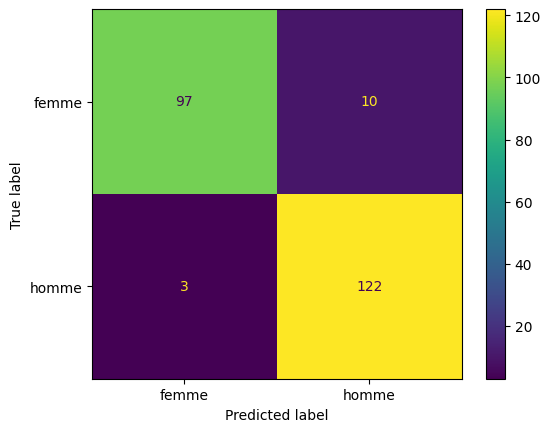

In [16]:
# Matrice de confusion
ConfusionMatrixDisplay.from_predictions(df_decisionrule['sex'], df_decisionrule['sex_pred'])

## Random forest

Pour utiliser une random forest, on doit avoir des inputs numériques. Il faut donc encoder les données catégorielles.

In [17]:
df_rf = df.drop(columns='prediction')

In [18]:
# Encodage du sexe
df_rf['sex'] = df_rf['sex'].apply(lambda x: 0 if x=='homme' else 1)

In [19]:
# Données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df_rf.drop(columns='sex'), df_rf['sex'], test_size=0.3, random_state=67)

In [38]:
# La grande majorité des professions n'apparaissent qu'une fois (patron 3, domestique 2, manoeuvre 2, sp 2, enttinateur 2), le reste 1.
df_rf['profession'].value_counts()

profession
None                      173
id                          8
patron                      3
"                           2
domestique                  2
manoeuvre                   2
sp                          2
enttinateur                 2
eublinateur                 1
culsinière                  1
san pla                     1
naveur euregestrement       1
D                           1
S por                       1
lavane                      1
Menuisier                   1
Menseuvr                    1
Louv fils                   1
represt de pamis            1
métag                       1
profevitaire                1
entiinateur                 1
href                        1
Cubsinière                  1
eublinat                    1
repasseuse                  1
Employé                     1
charesier                   1
emp pils                    1
cuisinière                  1
culviciste                  1
voiturier                   1
Ed                          1

Pour la relation et les prénoms, on utilise un TargetEncoder.
Pour la profession, on va seulement encoder "activité professionnelle" ou "pas d'activité professionnelle".

In [20]:
class ProfessionEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, pos_labels, columns):
        self.pos_labels = pos_labels
        self.columns = columns
    
    def fit(self, X=None, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.columns] = X[self.columns].apply(lambda x: 0 if x in self.pos_labels else 1)
        return X

In [21]:
# Preprocessing

target_categorical_features = ["firstname", "relation"]
categorical_transformer = Pipeline(
    steps=[("encoder", TargetEncoder(shuffle=False))]
)

profession_transformer = Pipeline(
    steps=[("encoder", ProfessionEncoder(['None', 'sp'], 'profession'))]
)

numeric_features = ["male_frequency"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, target_categorical_features),
        ("pro", profession_transformer, ["profession"])
    ]
)

In [22]:
# Grille d'hyperparamètres
param_grid = {
    'classifier__n_estimators': [50, 75, 100, 200],
    'classifier__max_depth': [3, 5, None],
    'classifier__max_features': ['sqrt', None]
}

pipeline = Pipeline(steps=[('transformer', preprocessor), ('classifier', RandomForestClassifier(random_state=7888))])

# Gridsearch avec validation croisée pour trouver les meilleurs hyperparamètres
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['male_frequency']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('encoder',
                                                                                          TargetEncoder(shuffle=False))]),
                                                                         ['firstname',
                                                                          'relation']),
                                                                        ('pro',
                                                                         Pipeline(steps=[('encoder',
                                                                                          ProfessionEncoder(columns='profession',
                                                                                                            pos_labels=['None',
                                                                                                                        'sp']))]),
                                                                         ['profession'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=7888))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [3, 5, None],
                         'classifier__max_features': ['sqrt', None],
                         'classifier__n_estimators': [50, 75, 100, 200]},
             scoring='accuracy')

In [23]:
# Meilleur modèle
best_rf = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        87
           1       0.99      1.00      0.99        75

    accuracy                           0.99       162
   macro avg       0.99      0.99      0.99       162
weighted avg       0.99      0.99      0.99       162

              precision    recall  f1-score   support

           0       0.97      0.92      0.95        38
           1       0.91      0.97      0.94        32

    accuracy                           0.94        70
   macro avg       0.94      0.94      0.94        70
weighted avg       0.94      0.94      0.94        70



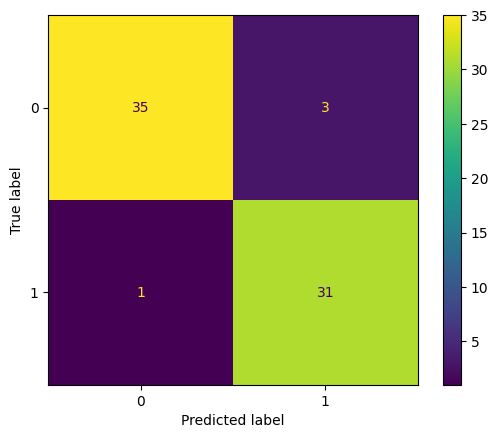

In [24]:
# Prédictions sur les sets d'entraînement et de test

y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

print(classification_report(y_train, y_pred_train))

print(classification_report(y_test, y_pred_test))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)

# Camembert

In [25]:
# Import du modèle et du tokenizer
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForSequenceClassification.from_pretrained("camembert-base")

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [26]:
# Garder uniquement les deux dernières couches (qui correspondent au classifier) comme entraînables
for name, param in model.named_parameters():
    param.requires_grad = True if name.startswith('classifier') else False

In [27]:
# Initialiser les poids des couches de classification
torch.manual_seed(42)
np.random.seed(42)

model.classifier.dense.weight.data.normal_(mean=0.0, std=0.02)
model.classifier.dense.bias.data.zero_()
model.classifier.out_proj.weight.data.normal_(mean=0.0, std=0.02)
model.classifier.out_proj.bias.data.zero_()

tensor([0., 0.], device='cuda:0')

In [28]:
def male_frequency(input):
    return 'inconnue' if (np.isnan(input)) else round(input, 2)

def columns_to_text(row):
    return f"prénom: {row['firstname']} relation: {row['relation']} profession: {row['profession']} fréquence d'hommes: {male_frequency(row['male_frequency'])}"

In [29]:
df_camembert = df.copy()

# Remplacer 'None' par 'inconnue' (plus compréhensible par un modèle français)
df_camembert['relation'] = df_camembert['relation'].apply(lambda x: x.lower().replace("none", "inconnue"))
df_camembert['profession'] = df_camembert['profession'].apply(lambda x: x.lower().replace("none", "inconnue").replace("sp", "aucune"))

# Rassembler les informations utiles en une seule phrase
df_camembert['text'] = df_camembert.apply(columns_to_text, axis=1)

# Supprimer les autres colonnes
df_camembert.drop(columns=['prediction', 'firstname', 'profession', 'relation', 'male_frequency'], inplace=True)

# Encoder le sexe
df_camembert['sex'] = df_camembert['sex'].apply(lambda x: 0 if x=='homme' else 1)

In [30]:
class TranscriptionsDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        label = self.data.iloc[idx]['sex']
        return {'text': text, 'label': label}

In [31]:
# Sets d'entraînement, de validation et de test
train_df, test_df = train_test_split(df_camembert, test_size=0.3, random_state=44)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_dataset = TranscriptionsDataset(train_df)
val_dataset = TranscriptionsDataset(val_df)
test_dataset = TranscriptionsDataset(test_df)

In [32]:
def tokenize_batch(samples, tokenizer):
    text = [sample["text"] for sample in samples]
    labels = torch.tensor([sample["label"] for sample in samples])
    tokens = tokenizer(text, padding="longest", truncation=True, return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "sentences": text}

In [33]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer), shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer))
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer))

In [34]:
def evaluate_accuracy(model, loader, device):
    """Renvoie la précision du modèle sur le set contenu dans loader"""
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            correct += torch.sum(predictions == labels).item()
            total += logits.size(0)

    accuracy = correct / total
    return accuracy

In [35]:
def train(model, num_epochs=20, lr=1e-2):
    """Entraîne les couches de classification du modèle"""

    optim = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for batch in tqdm(train_loader):
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            epoch_loss += loss.item()

            # Backward pass
            optim.zero_grad()
            loss.backward()
            optim.step()

        # Précisions et perte
        train_acc = evaluate_accuracy(model, train_loader, device)
        val_acc = evaluate_accuracy(model, val_loader, device)
        print ('Epoch [{}/{}], Loss: {:.4f} - Train accuracy {:.4f} - Validation accuracy {:.4f}' 
                    .format(epoch+1, num_epochs, epoch_loss / len(train_loader), train_acc, val_acc))
        
    model.eval()

In [36]:
# Entraînement du modèle
train(model)

100%|██████████| 19/19 [00:05<00:00,  3.23it/s]


Epoch [1/20], Loss: 1.7042 - Train accuracy 0.5448 - Validation accuracy 0.5882


100%|██████████| 19/19 [00:00<00:00, 31.35it/s]


Epoch [2/20], Loss: 0.8504 - Train accuracy 0.4621 - Validation accuracy 0.4706


100%|██████████| 19/19 [00:00<00:00, 33.97it/s]


Epoch [3/20], Loss: 0.7989 - Train accuracy 0.7655 - Validation accuracy 0.5294


100%|██████████| 19/19 [00:00<00:00, 36.07it/s]


Epoch [4/20], Loss: 0.6272 - Train accuracy 0.7517 - Validation accuracy 0.8235


100%|██████████| 19/19 [00:00<00:00, 35.41it/s]


Epoch [5/20], Loss: 0.7165 - Train accuracy 0.8966 - Validation accuracy 0.9412


100%|██████████| 19/19 [00:00<00:00, 34.94it/s]


Epoch [6/20], Loss: 0.4081 - Train accuracy 0.6828 - Validation accuracy 0.5882


100%|██████████| 19/19 [00:00<00:00, 36.72it/s]


Epoch [7/20], Loss: 0.5504 - Train accuracy 0.5448 - Validation accuracy 0.5882


100%|██████████| 19/19 [00:00<00:00, 34.61it/s]


Epoch [8/20], Loss: 1.0823 - Train accuracy 0.9172 - Validation accuracy 0.9412


100%|██████████| 19/19 [00:00<00:00, 33.17it/s]


Epoch [9/20], Loss: 0.5819 - Train accuracy 0.9034 - Validation accuracy 0.9412


100%|██████████| 19/19 [00:00<00:00, 36.86it/s]


Epoch [10/20], Loss: 0.9046 - Train accuracy 0.5448 - Validation accuracy 0.5882


100%|██████████| 19/19 [00:00<00:00, 34.95it/s]


Epoch [11/20], Loss: 0.6182 - Train accuracy 0.8828 - Validation accuracy 0.8824


100%|██████████| 19/19 [00:00<00:00, 30.42it/s]


Epoch [12/20], Loss: 0.5197 - Train accuracy 0.9241 - Validation accuracy 0.9412


100%|██████████| 19/19 [00:00<00:00, 30.52it/s]


Epoch [13/20], Loss: 1.1237 - Train accuracy 0.7103 - Validation accuracy 0.6471


100%|██████████| 19/19 [00:00<00:00, 33.33it/s]


Epoch [14/20], Loss: 2.5215 - Train accuracy 0.8966 - Validation accuracy 0.8824


100%|██████████| 19/19 [00:00<00:00, 34.41it/s]


Epoch [15/20], Loss: 1.7470 - Train accuracy 0.8966 - Validation accuracy 0.8824


100%|██████████| 19/19 [00:00<00:00, 30.24it/s]


Epoch [16/20], Loss: 0.6301 - Train accuracy 0.5448 - Validation accuracy 0.5882


100%|██████████| 19/19 [00:00<00:00, 31.78it/s]


Epoch [17/20], Loss: 0.6827 - Train accuracy 0.8276 - Validation accuracy 0.8824


100%|██████████| 19/19 [00:00<00:00, 33.06it/s]


Epoch [18/20], Loss: 0.8231 - Train accuracy 0.8690 - Validation accuracy 0.8824


100%|██████████| 19/19 [00:00<00:00, 33.28it/s]


Epoch [19/20], Loss: 1.2250 - Train accuracy 0.8345 - Validation accuracy 0.8824


100%|██████████| 19/19 [00:00<00:00, 37.86it/s]


Epoch [20/20], Loss: 0.9502 - Train accuracy 0.9793 - Validation accuracy 1.0000


In [37]:
# Précision sur le set de test
evaluate_accuracy(model, test_loader, device)

0.9428571428571428

Si on change le random_state dans le train_test_split, et qu'on execute toute la partie Camembert, voici les précisions sur le set de test:
- random_state = 42 : 0.96
- random_state = 43 : 0.90
- random_state = 44 : 0.94
- random_state = 47 : 0.87
- random_state = 57 : 0.91
- random_state = 9999 : 0.92
- random_state = 897 : 0.94
- random_state = 90 : 0.80